# Single Side Band ptychography example

This example uses an implementation of the single side band method
https://doi.org/10.1016/j.ultramic.2014.09.013 to reconstruct an amplitude and phase
image from a simulated 4D scanning transmission electron microscopy dataset with an additional synthetic
potential modulation.

In [1]:
import os

import matplotlib.pyplot as plt
import libertem.api as lt
import numpy as np
from matplotlib import colors

# note: visulization requires empyre
# install empyre: pip install empyre
from empyre.vis.colors import ColormapCubehelix

from libertem import masks
from libertem.udf.sum import SumUDF
from libertem.executor.inline import InlineJobExecutor
from libertem.common.container import MaskContainer
from libertem.common.backend import set_use_cuda, set_use_cpu, get_device_class
from libertem.corrections.coordinates import identity

In [2]:
from ptychography.reconstruction.ssb import SSB_UDF, generate_masks, get_results
from ptychography.reconstruction.common import wavelength, get_shifted

In [3]:
%matplotlib nbagg

## Create the LiberTEM contexts

We use a default distributed context for preliminary analyses. The inline context is used to perform the SSB calculation. An inline executor executes LiberTEM UDFs in the process where this script is running instead of running it on worker processes. This is currently more efficient for this SSB implementation since it allows to re-use precalculated data better. For most other applications, running on distributed workers is faster. See also https://github.com/LiberTEM/LiberTEM/issues/335

In [4]:
ctx = lt.Context()

inline_executor = InlineJobExecutor()
inline_ctx = lt.Context(executor=inline_executor)

c:\users\dwebe\.conda\envs\ptycho37\lib\site-packages\libertem\utils\devices.py:72: RuntimeWarning: CUDARuntimeError('cudaErrorUnsupportedPtxVersion: the provided PTX was compiled with an unsupported toolchain.')
  warnings.warn(repr(e), RuntimeWarning)


## Open the input data

This creates a LiberTEM dataset. The data is not loaded yet, but only when analyses are run on it.

In [5]:
file_params = {'path': 'E:/LargeData/LargeData/ER-C-1/projects/ptycho-4.0/data/live-ssb-paper/RefData/slice_00001_thick_1.9525_nm_blocksz100.raw',
          'dtype': 'float32', 'nav_shape': [100, 100], 'sig_shape': [596, 596]}
ds = ctx.load("RAW", **file_params)


## Reconstruction parameters

These have to be adapted for each dataset.

In [6]:
rec_params = {
    # NumPy base dtype for the calculation. Set to numpy.float64 for higher precision
    'dtype': np.float32,
    # Wavelength of the illuminating radiation in m
    'lamb': wavelength(300),
    # Scan step in x and y direction in m
    'dpix': 1.9525e-9/100,
    # Semiconvergence angle of the illumination in radians
    'semiconv': 23e-3/2,
    # Diameter of the zero order disk on the detector in pixels
    'semiconv_pix': 68,
    # Affine transformation matrix for adjusting rotation and handedness between scan and detector coordinates.
    # The scale is handled by the other parameters.
    'transformation': identity(),
    # Position of the direct beam on the detecot in px
    'cy': 297,
    'cx': 297,
    # Minimum size of a trotter. Increase this to suppress noise from very small trotters.
    'cutoff': 1
}
mask_params = {
    # Shape of the reconstructed area
    'reconstruct_shape': tuple(ds.shape.nav),
    # Shape of a detector frame
    'mask_shape': tuple(ds.shape.sig),
    # Use the faster shifting method to generate trotters
    'method': 'shift',
}

## Initial analysis of the dataset

We sum up all frames and confirm that size and position of the zero order beam match.

In [7]:
sum_udf = SumUDF()
sum_result = ctx.run_udf(dataset=ds, udf=sum_udf, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.02s/it]


<IPython.core.display.Javascript object>


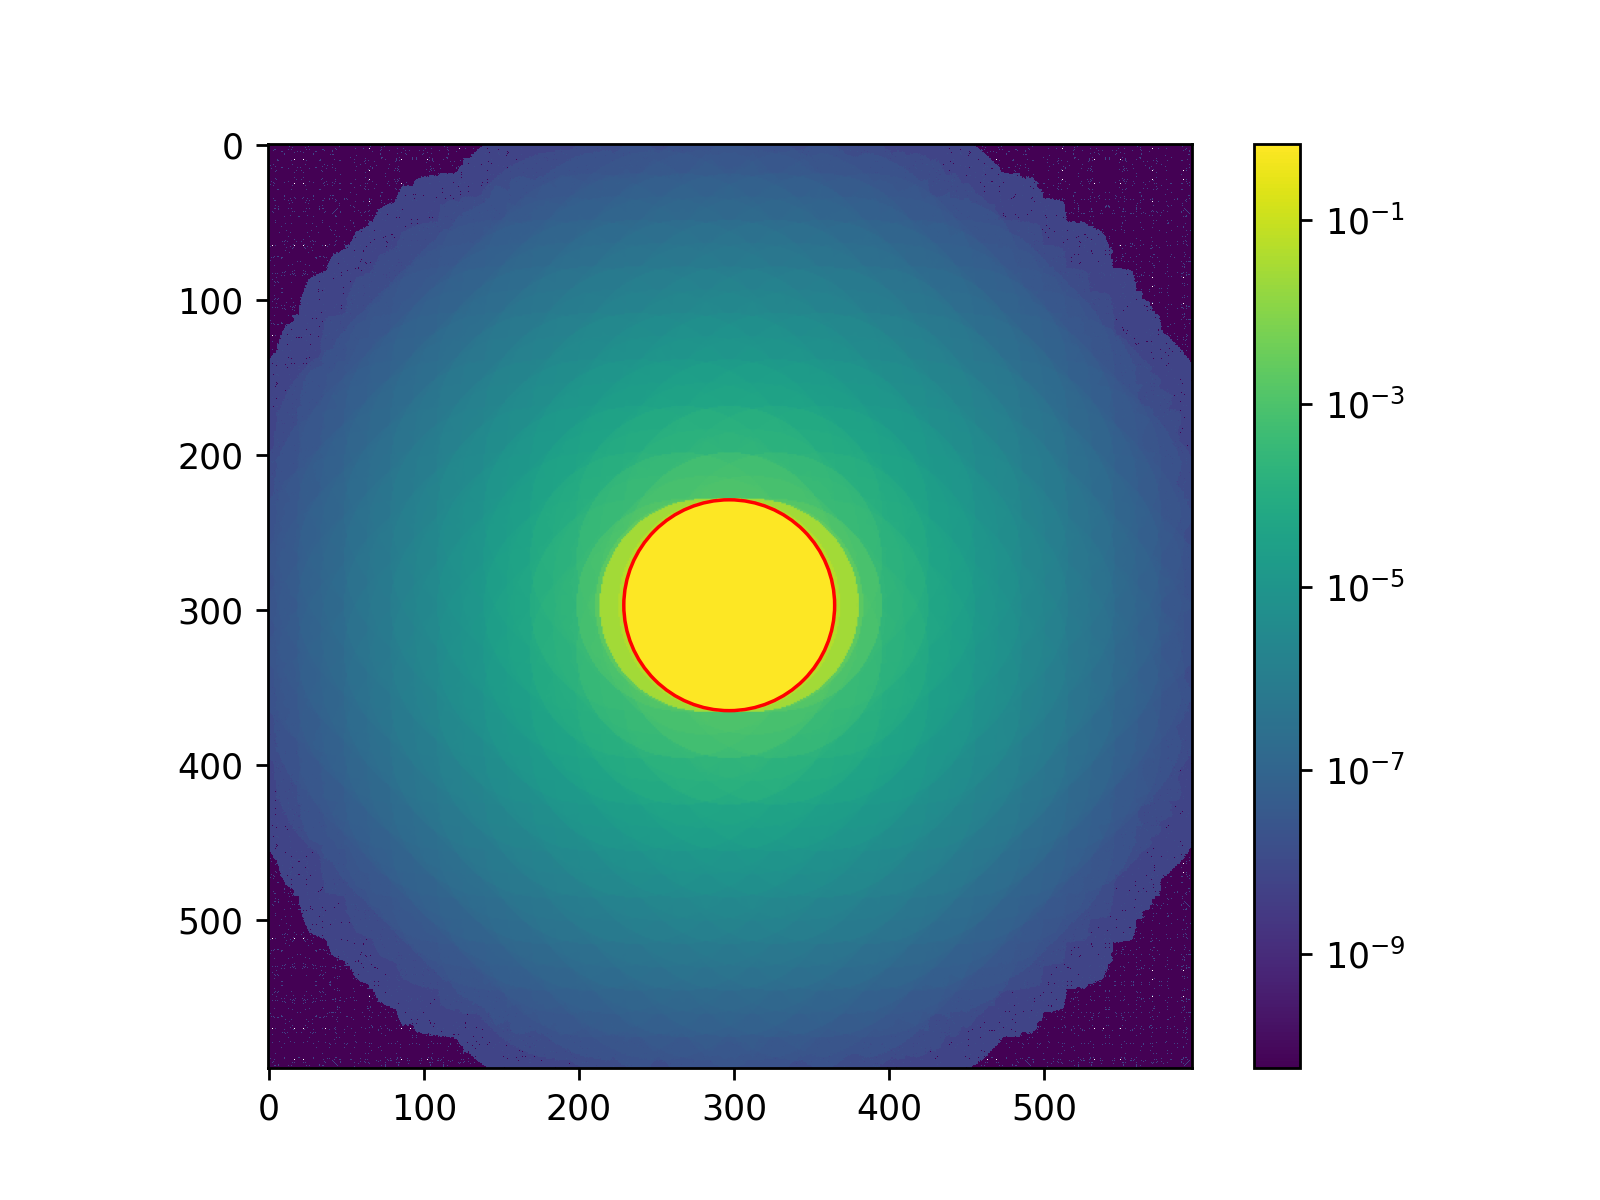

In [8]:
fig, axes = plt.subplots()
p = axes.imshow(sum_result['intensity'], norm=colors.LogNorm())
circ_a = plt.Circle((rec_params["cx"], rec_params["cy"]), rec_params["semiconv_pix"], fill=False, color='red')
axes.add_artist(circ_a)
fig.colorbar(p)

## Center of mass analysis

This is used to confirm that the coordinate system between scan and detector is properly adjusted. The beam should be deflected towards the nuclei for high resolution STEM data. That means that the field should have little curl and negative divergence at the position of the nuclei. Furthermore, x and y deflection should point towards the nuclei. See also https://libertem.github.io/LiberTEM/concepts.html#coordinate-system

In [9]:
com_analysis = ctx.create_com_analysis(
    dataset=ds,
    cx=rec_params["cx"],
    cy=rec_params["cy"],
    mask_radius=rec_params["semiconv_pix"] + 30
)
com_result = ctx.run(com_analysis, progress=True)
print(com_result)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.61it/s]

[<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: curl>, <AnalysisResult: x>, <AnalysisResult: y>]


<IPython.core.display.Javascript object>


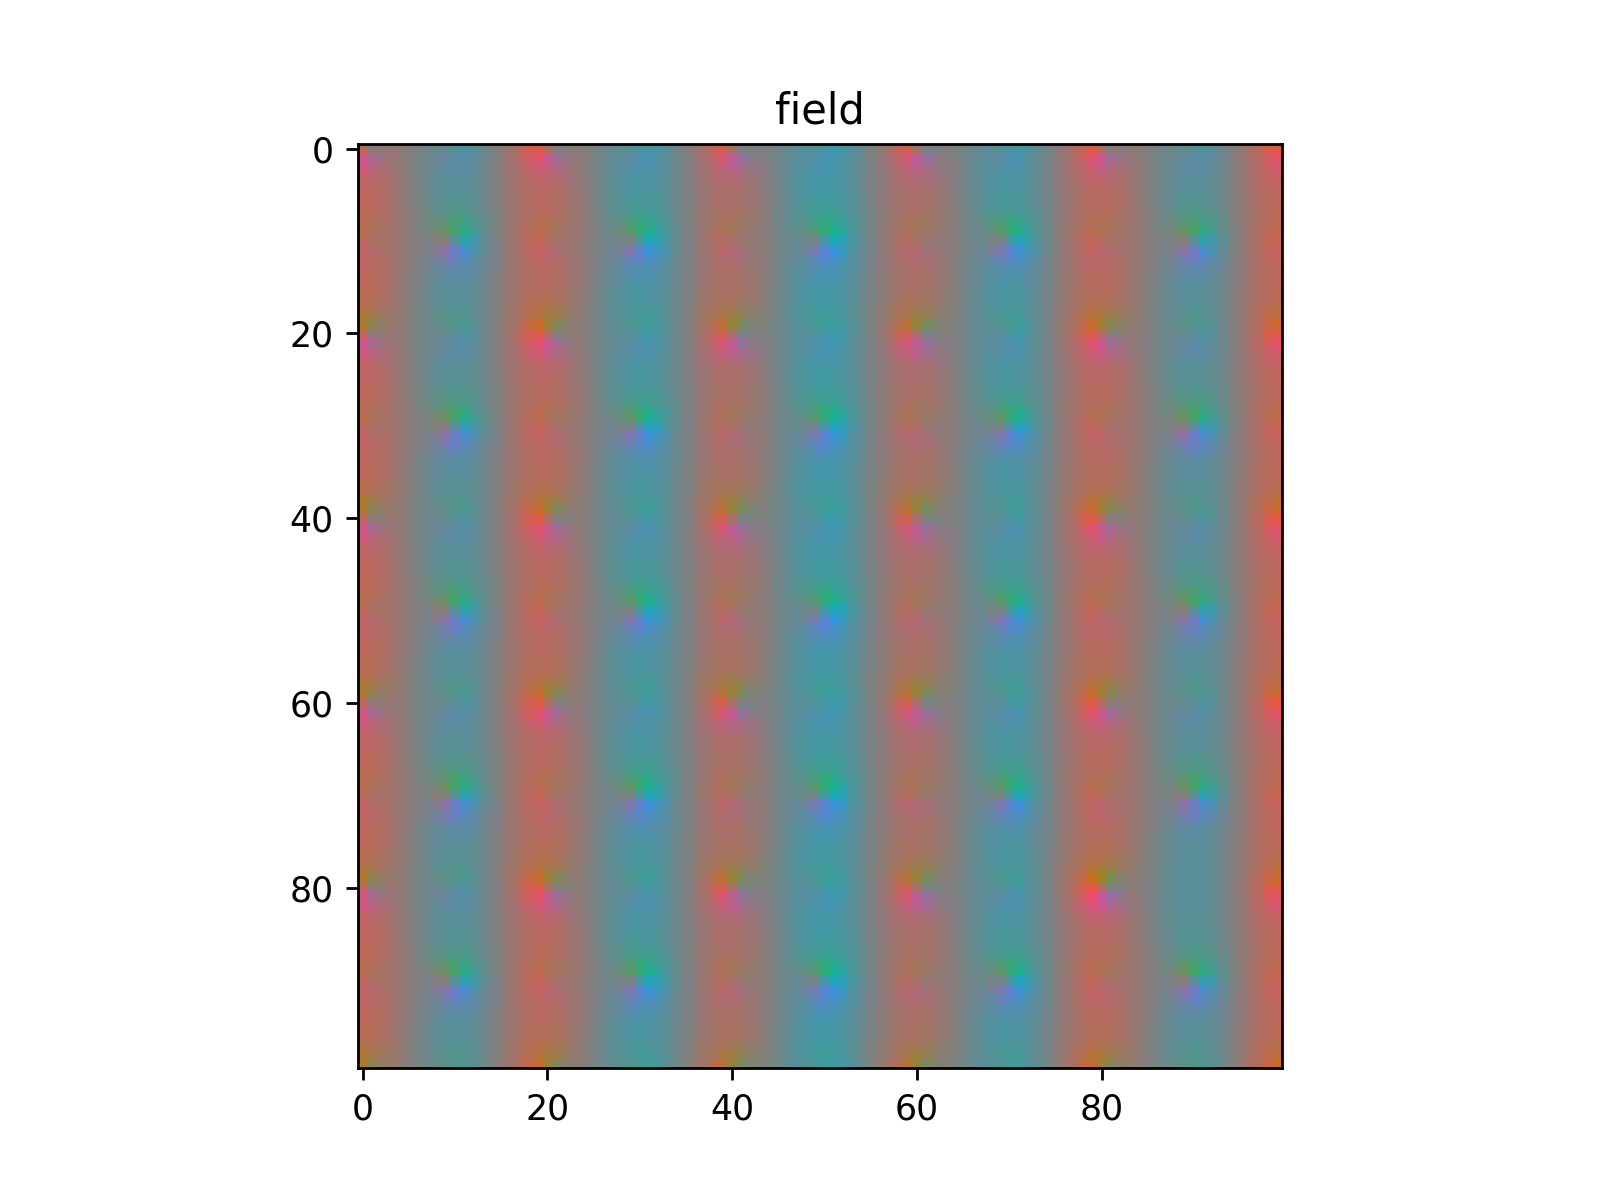

<IPython.core.display.Javascript object>


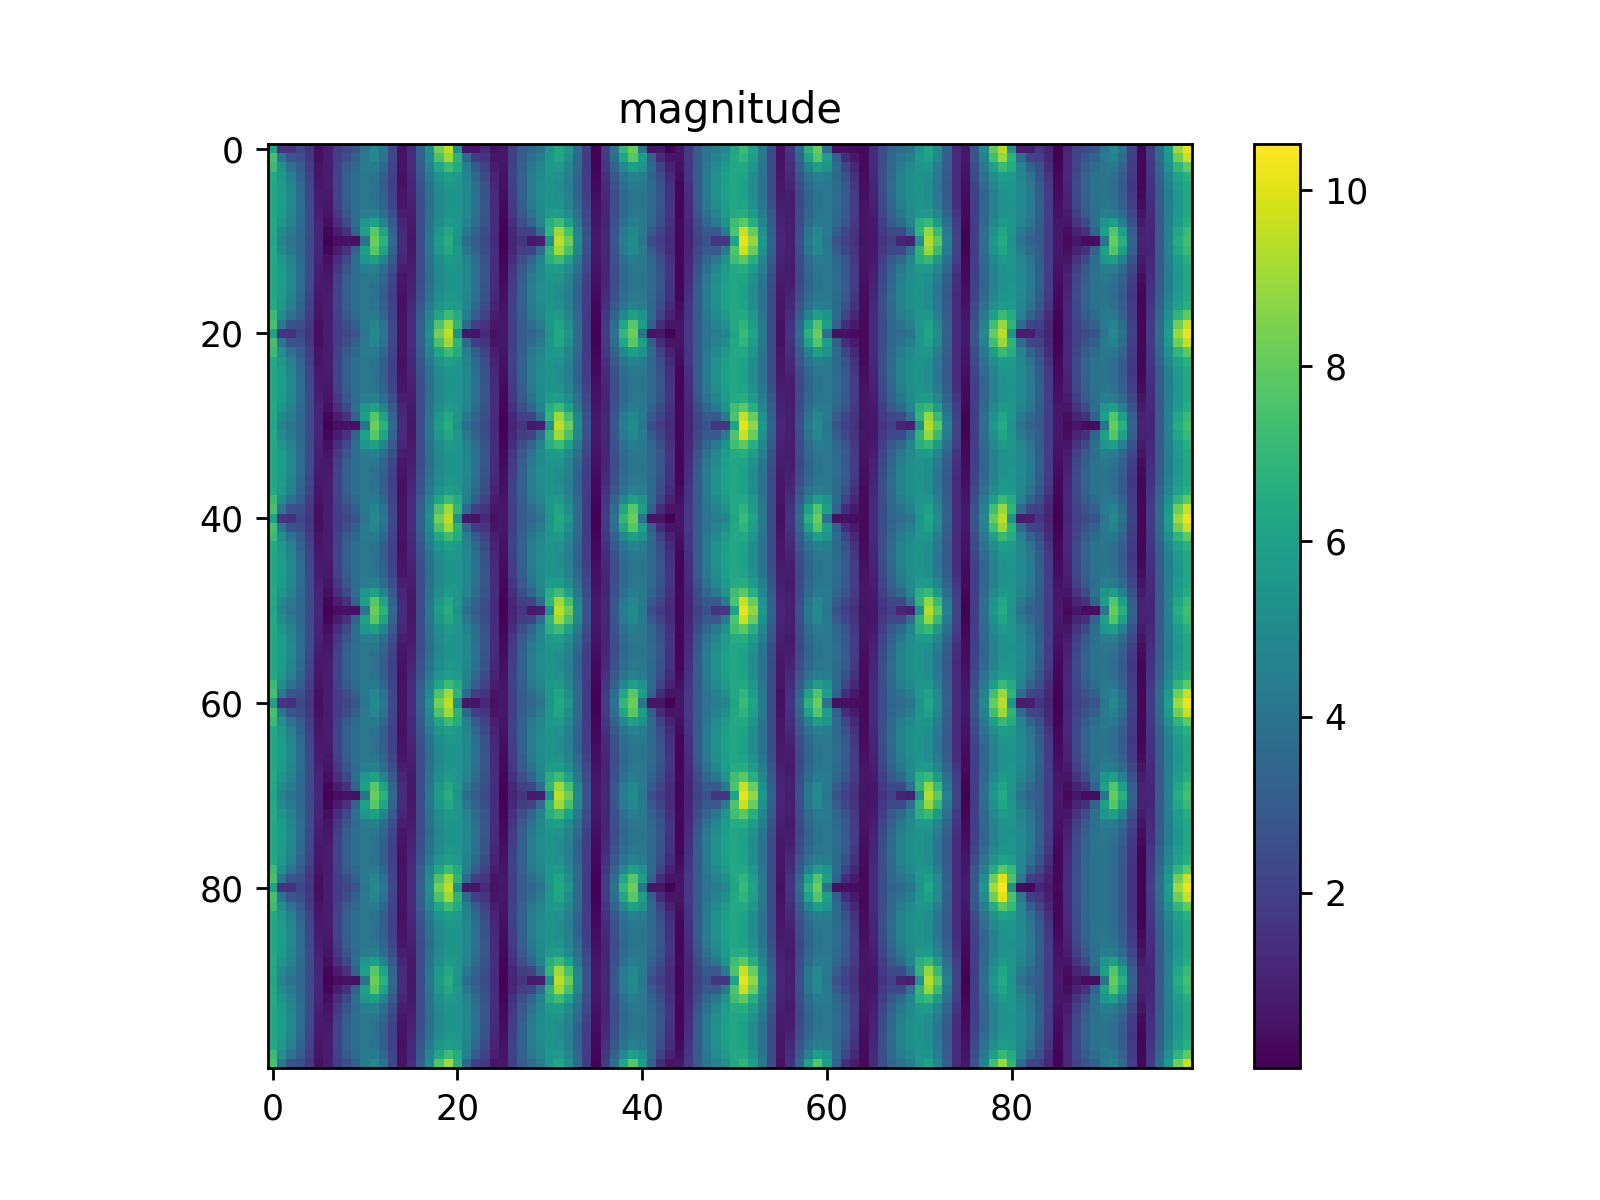

<IPython.core.display.Javascript object>


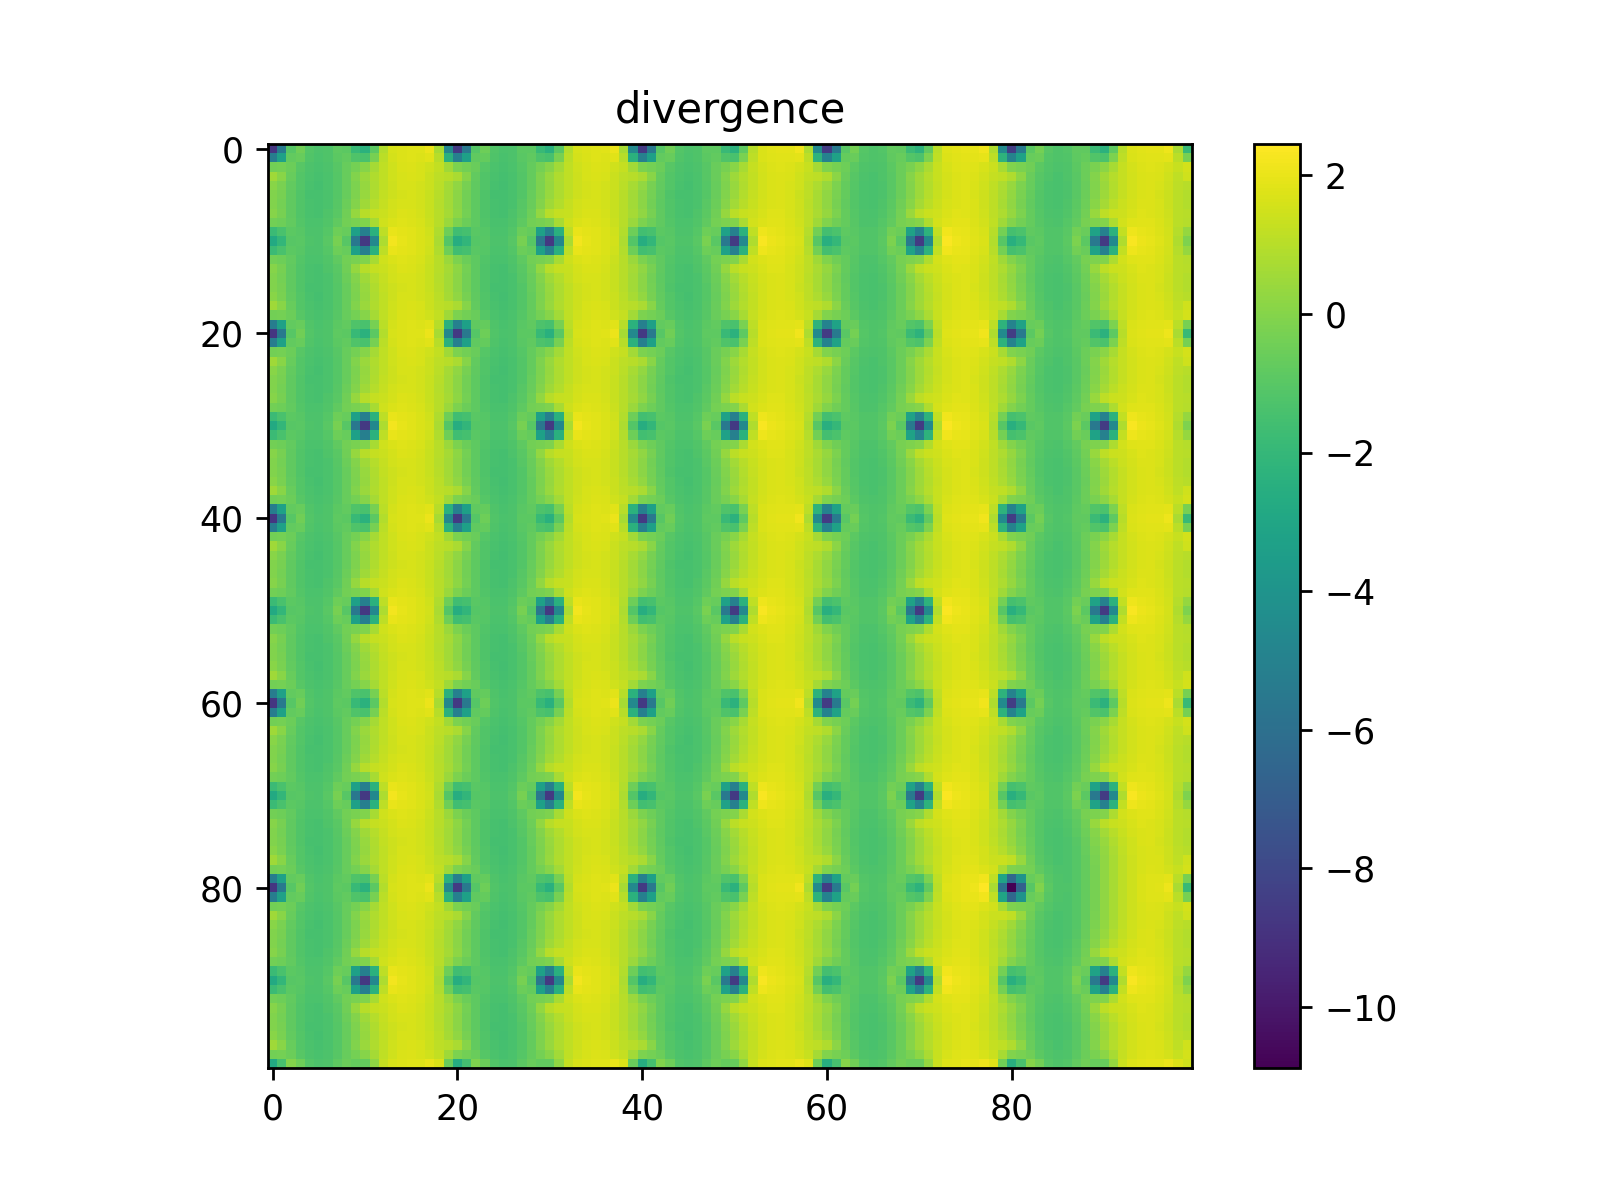

<IPython.core.display.Javascript object>


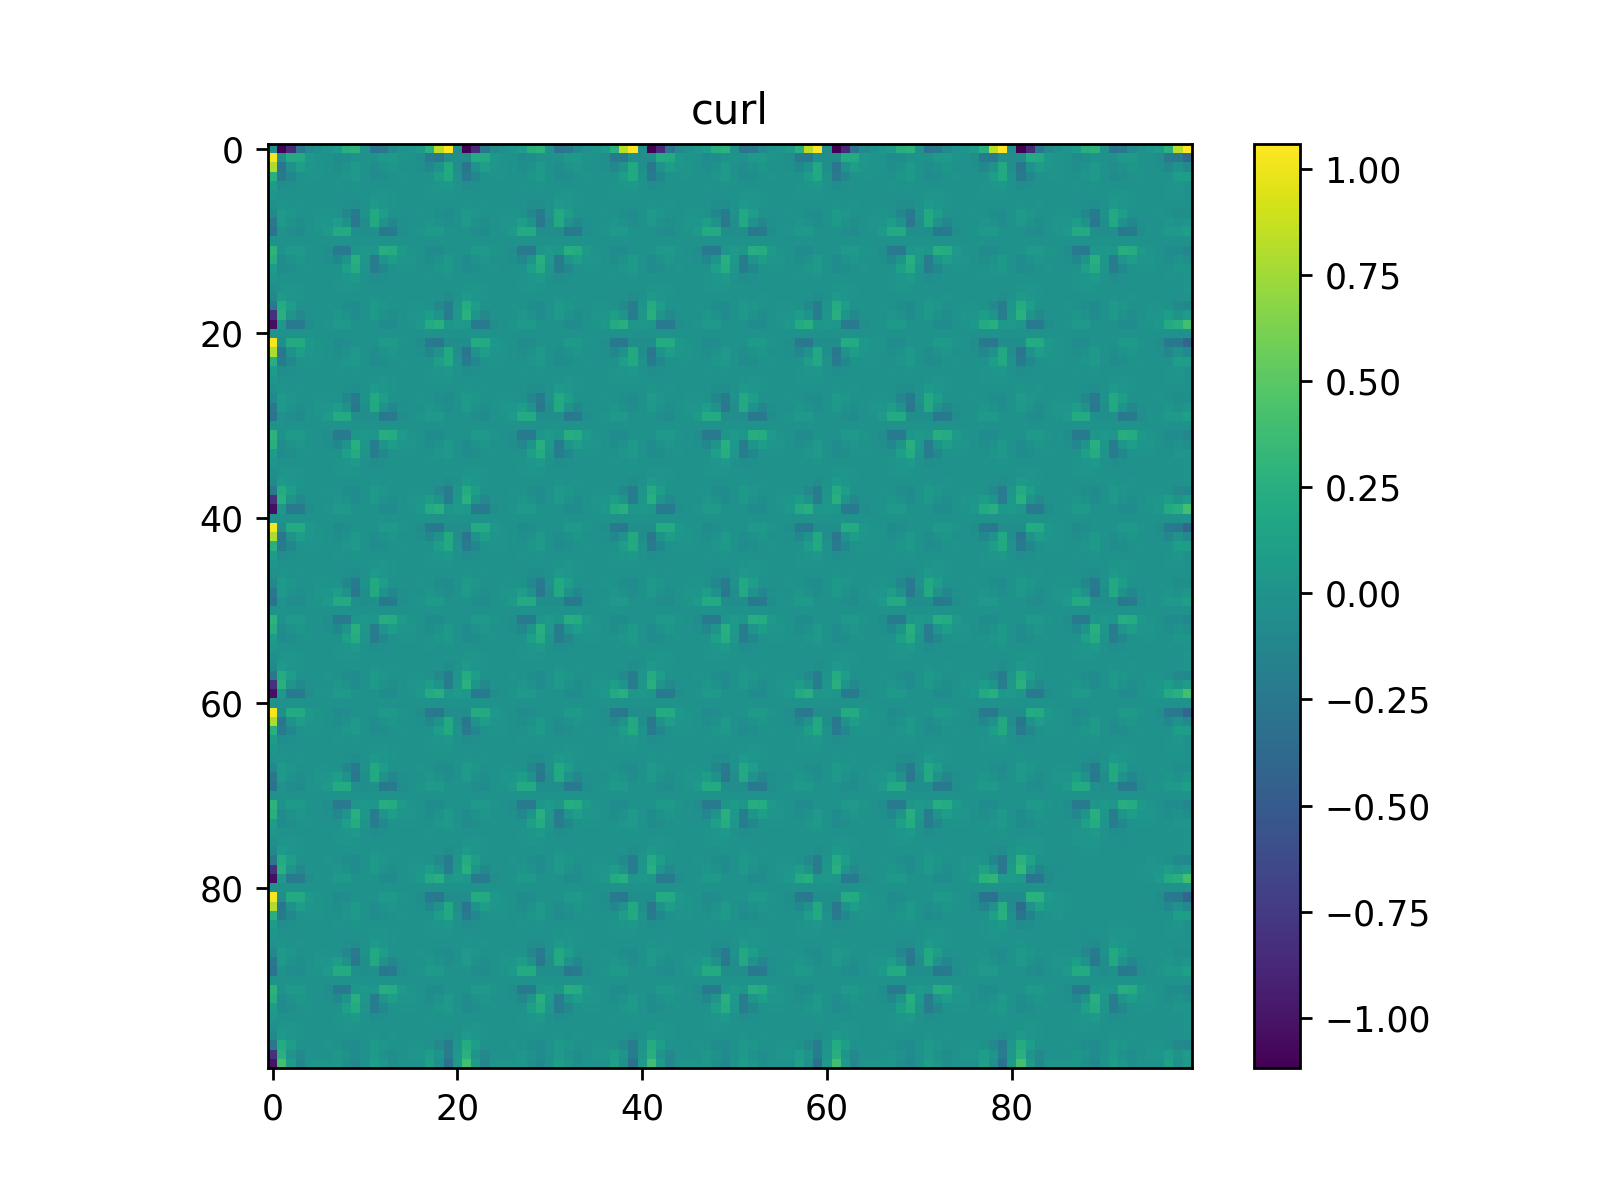

<IPython.core.display.Javascript object>


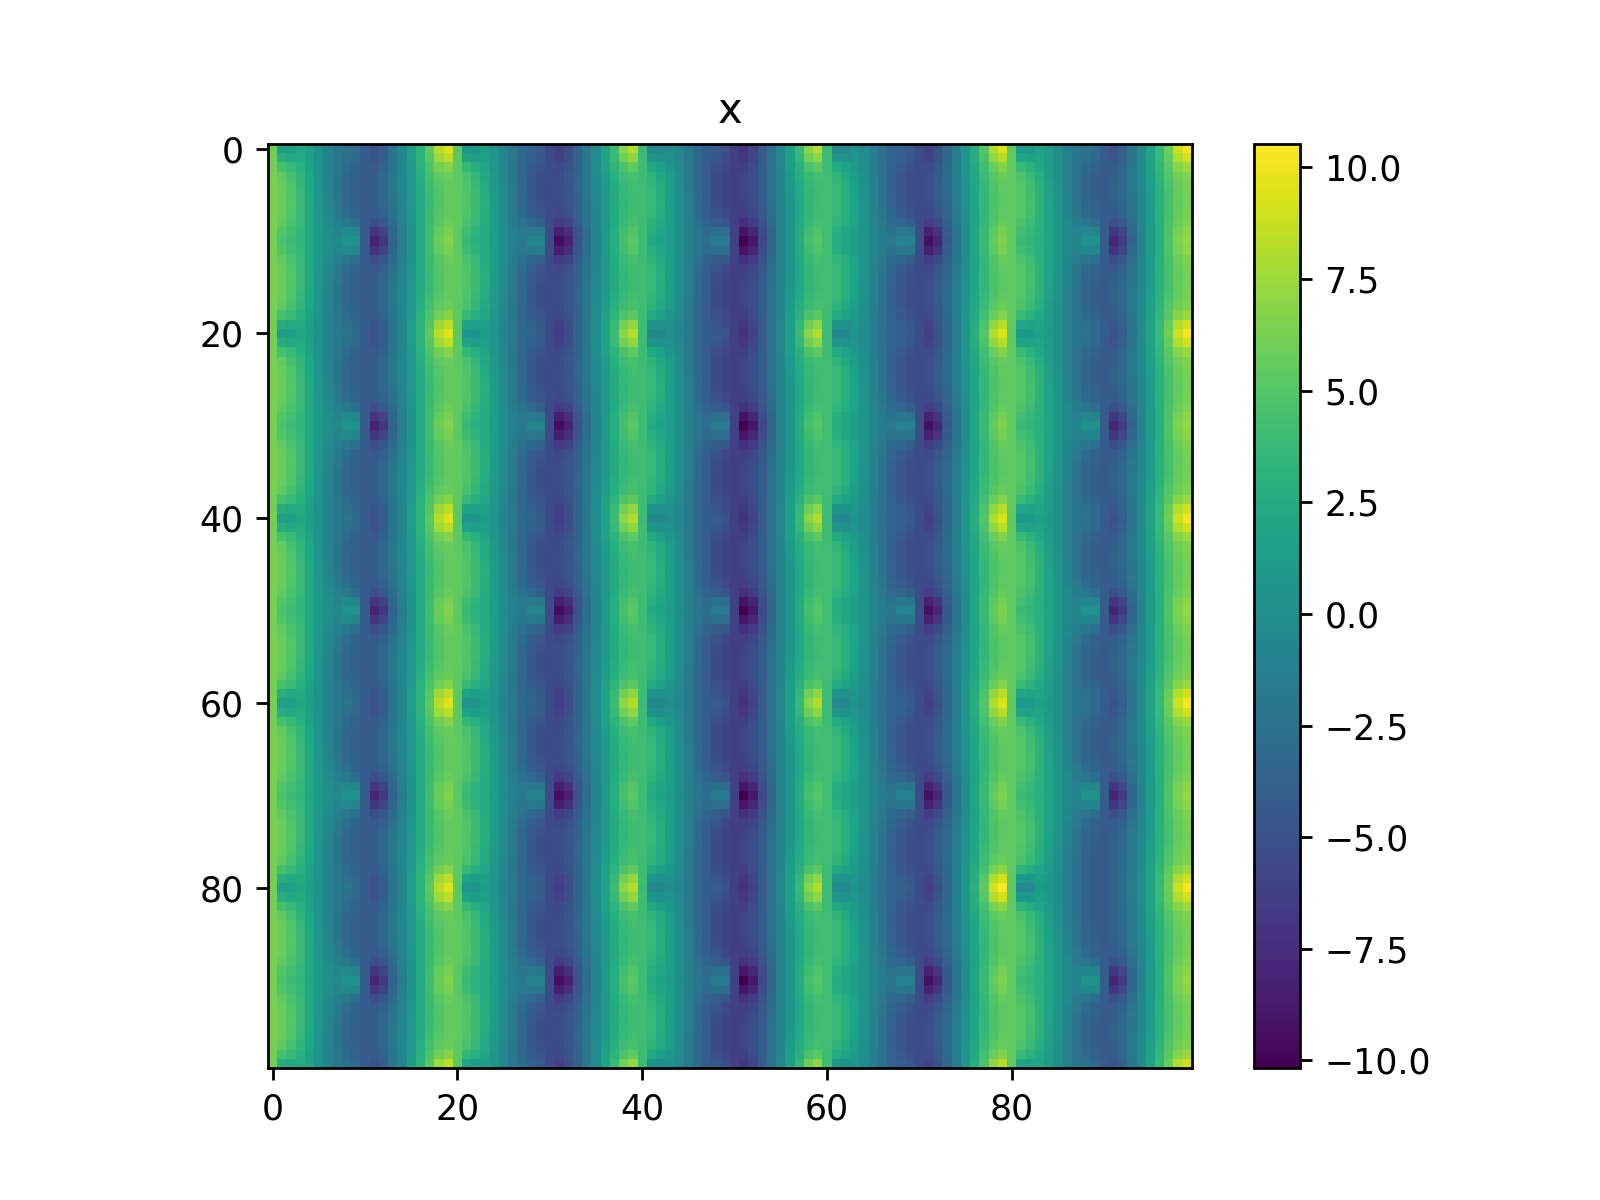

<IPython.core.display.Javascript object>


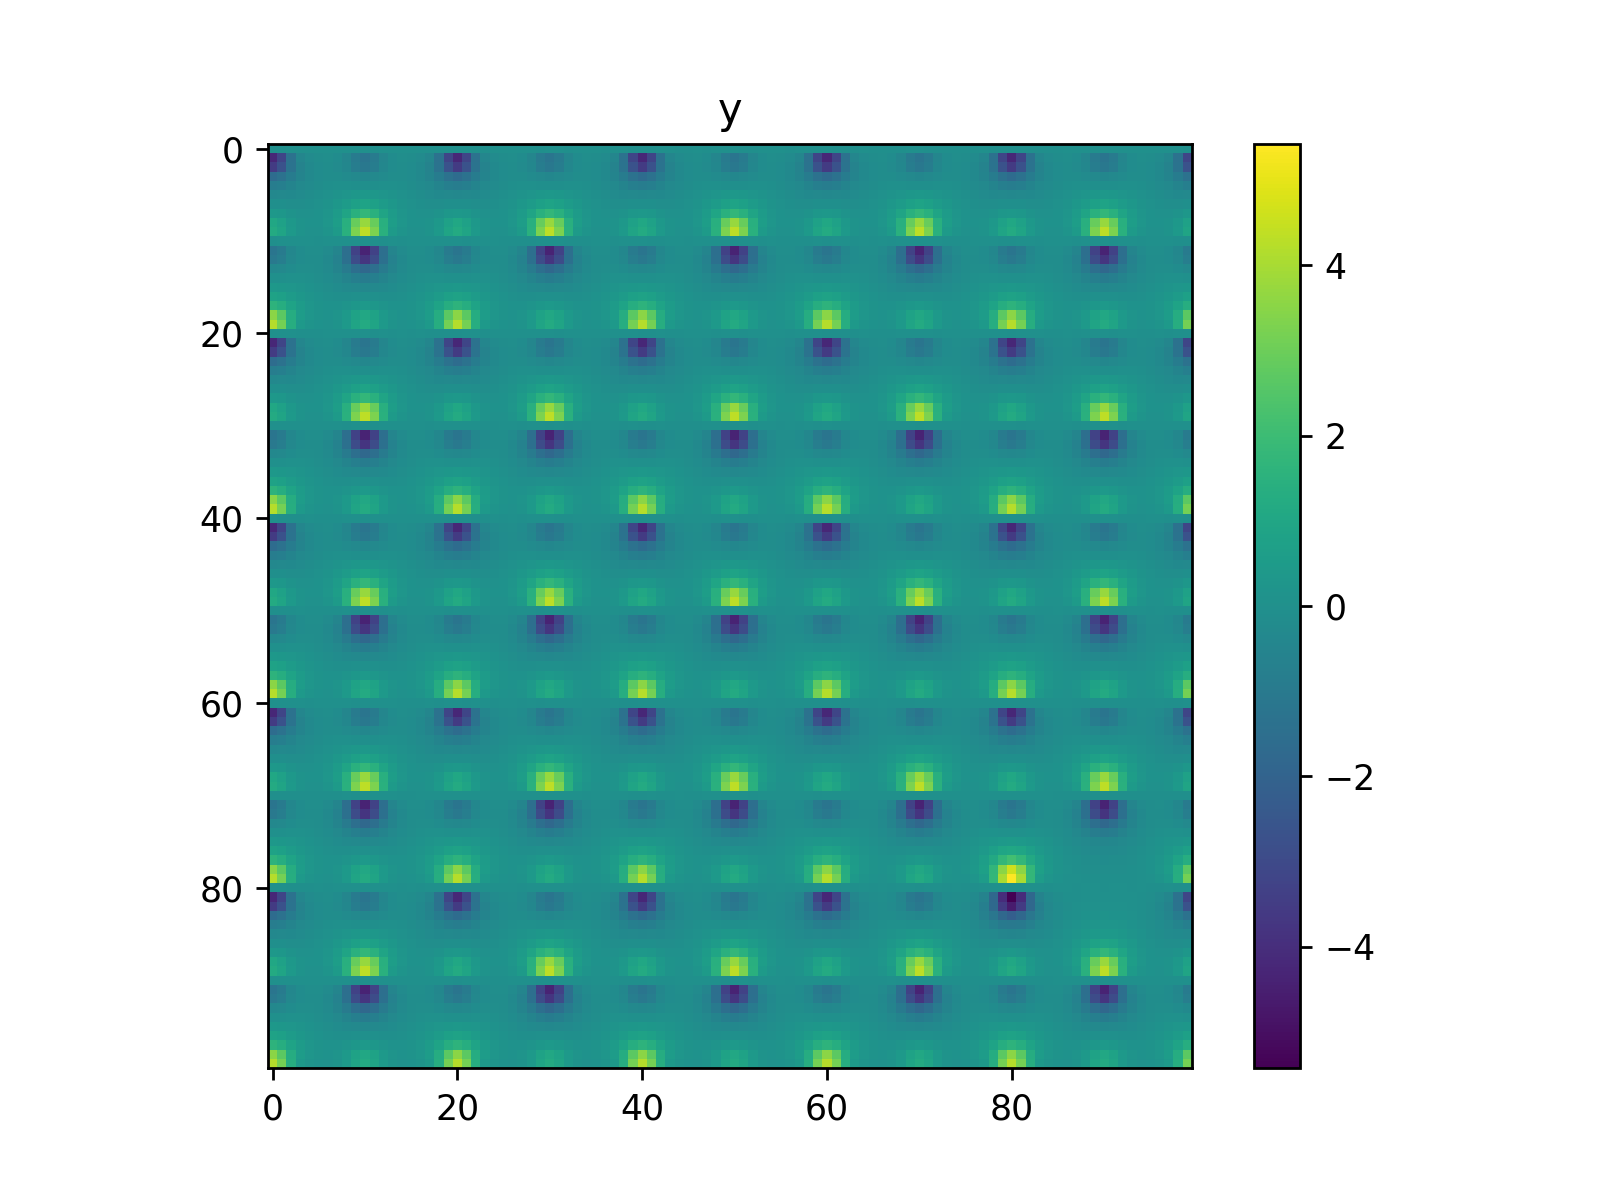

In [10]:
fig, axes = plt.subplots()
axes.set_title("field")
y_centers, x_centers = com_result.field.raw_data
ch = ColormapCubehelix(start=1, rot=1, minLight=0.5, maxLight=0.5, sat=2)
axes.imshow(ch.rgb_from_vector(np.broadcast_arrays(y_centers, x_centers, 0)))

fig, axes = plt.subplots()
axes.set_title("magnitude")
p = axes.imshow(com_result.magnitude.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("divergence")
p = axes.imshow(com_result.divergence.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("curl")
p = axes.imshow(com_result.curl.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("x")
p = axes.imshow(com_result.x.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("y")
p = axes.imshow(com_result.y.raw_data)
fig.colorbar(p)

## Pre-calculate the trotter stack

This takes some time and can be re-used for given reconstruction parameters. The stack is in a sparse matrix format.

In [11]:
%%time
trotters = generate_masks(**rec_params, **mask_params)

Wall time: 36.5 s


<IPython.core.display.Javascript object>


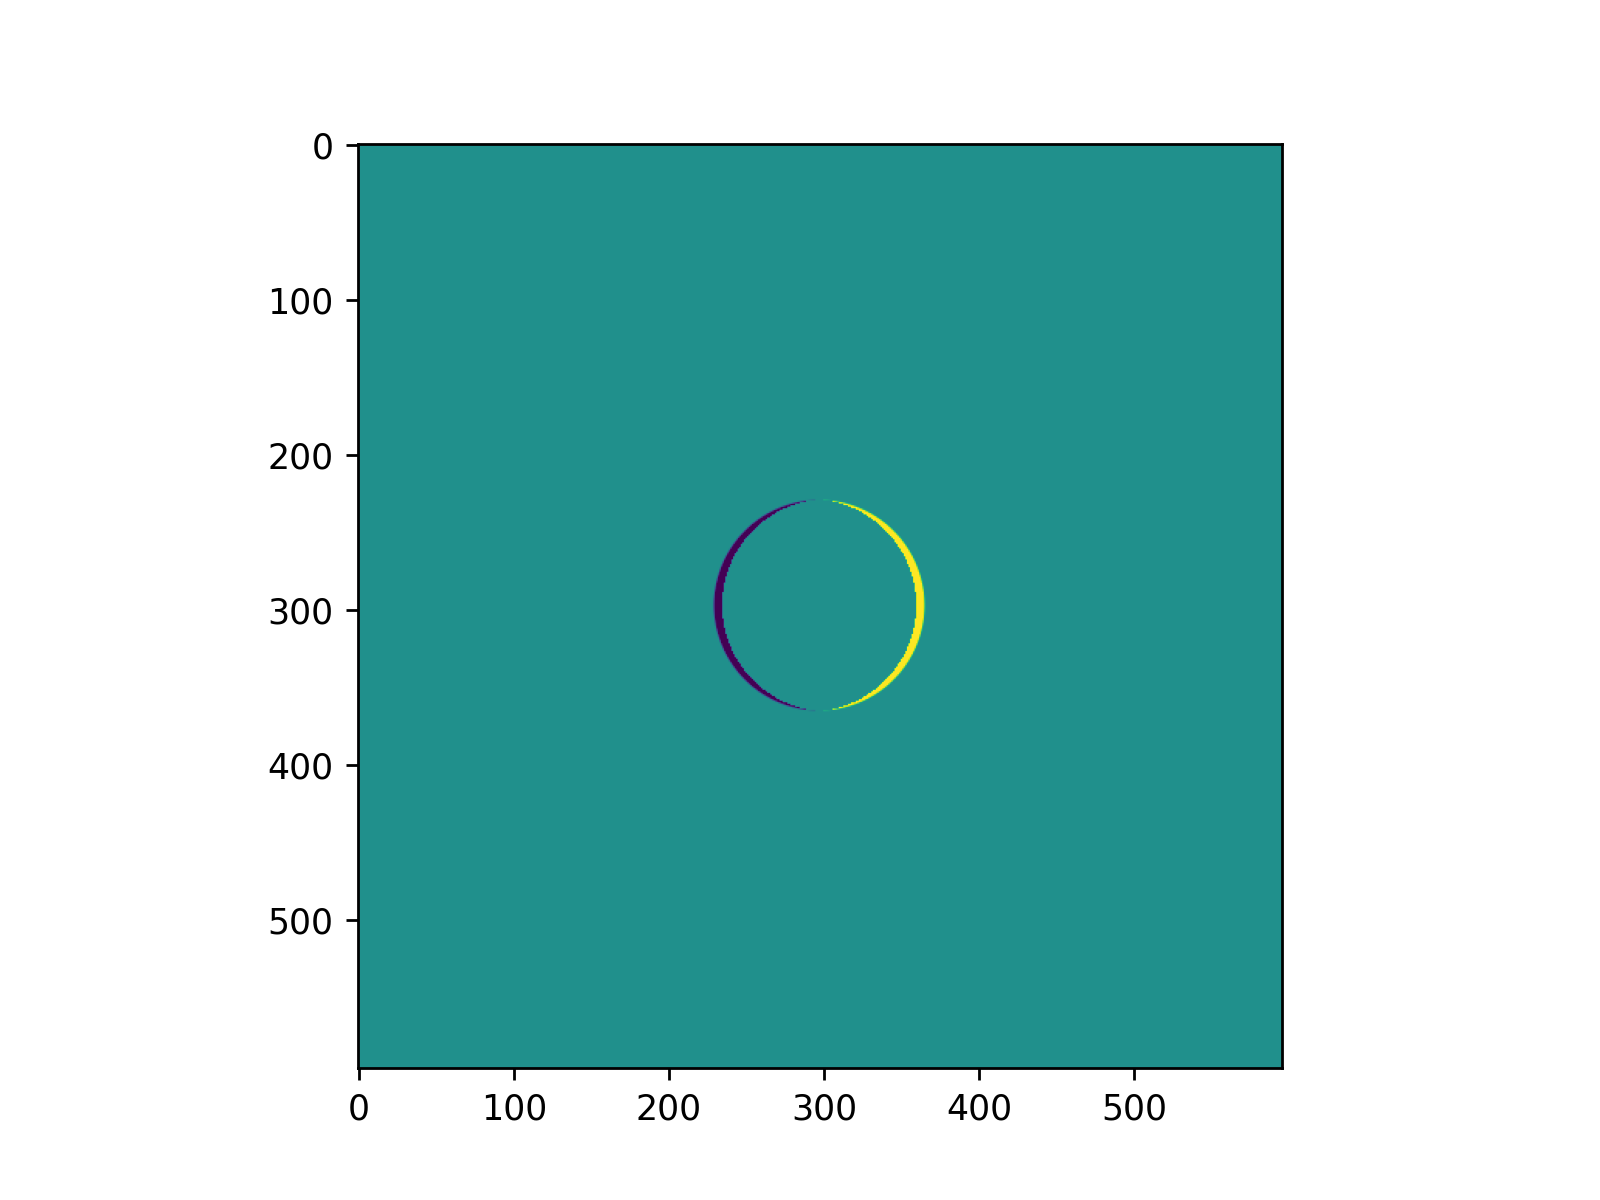

In [12]:
fig, axes = plt.subplots()
axes.imshow(trotters[1].todense())

Uncomment to use GPU processing on device 0 with the inline executor

In [13]:
# set_use_cuda(0)

We create a LiberTEM `MaskContainer` from the mask stack. The `MaskContainer` is used to calculate and cache subsets of the mask stack with optimized properties for a fast dot product and tiled processing.

In [14]:
mask_container = MaskContainer(
    mask_factories=lambda: trotters, dtype=trotters.dtype, count=trotters.shape[0]
)

Mask factory size 132952062 larger than warning limit 1048576, may be inefficient


## Instantiate and run the SSB UDF
The mask_container is passed to the UDF to allow re-use. This is a work-around for https://github.com/LiberTEM/LiberTEM/issues/335

In [15]:
udf = SSB_UDF(**rec_params, mask_container=mask_container)

In [16]:
%%time
# We use the inline executor since the sparse matrix stack is quite large.
# It would have to be in shared memory between workers and be re-used between
# partitions to be efficient, which is not supported yet in LiberTEM in
# the distributed case. Using the inline executor allows to re-use the masks
# and the cache of MaskContainer between partitions, which outweighs any benefits
# of parallelism in this case.
# See also https://github.com/LiberTEM/LiberTEM/issues/335
udf_result = inline_ctx.run_udf(udf=udf, dataset=ds, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:21<00:00,  5.83s/it]

Wall time: 1min 21s


## Show amplitude and phase of the reconstruction

<IPython.core.display.Javascript object>


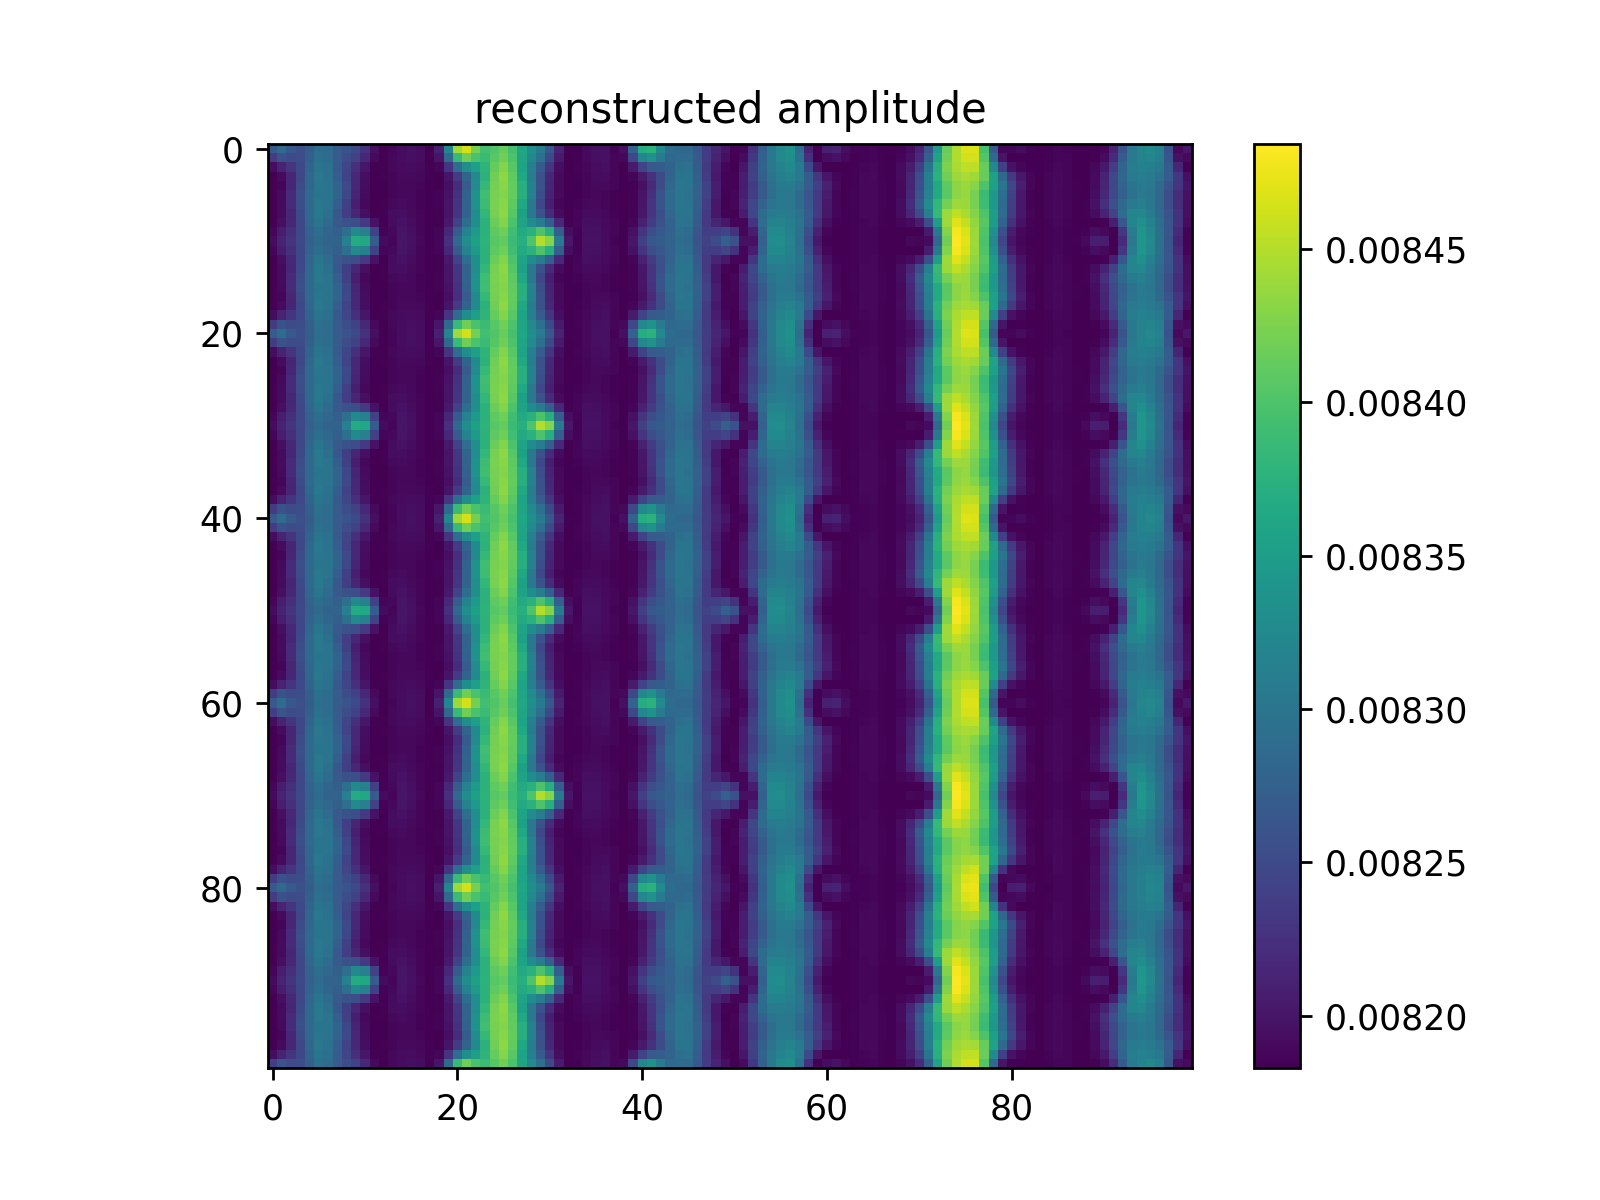

<IPython.core.display.Javascript object>


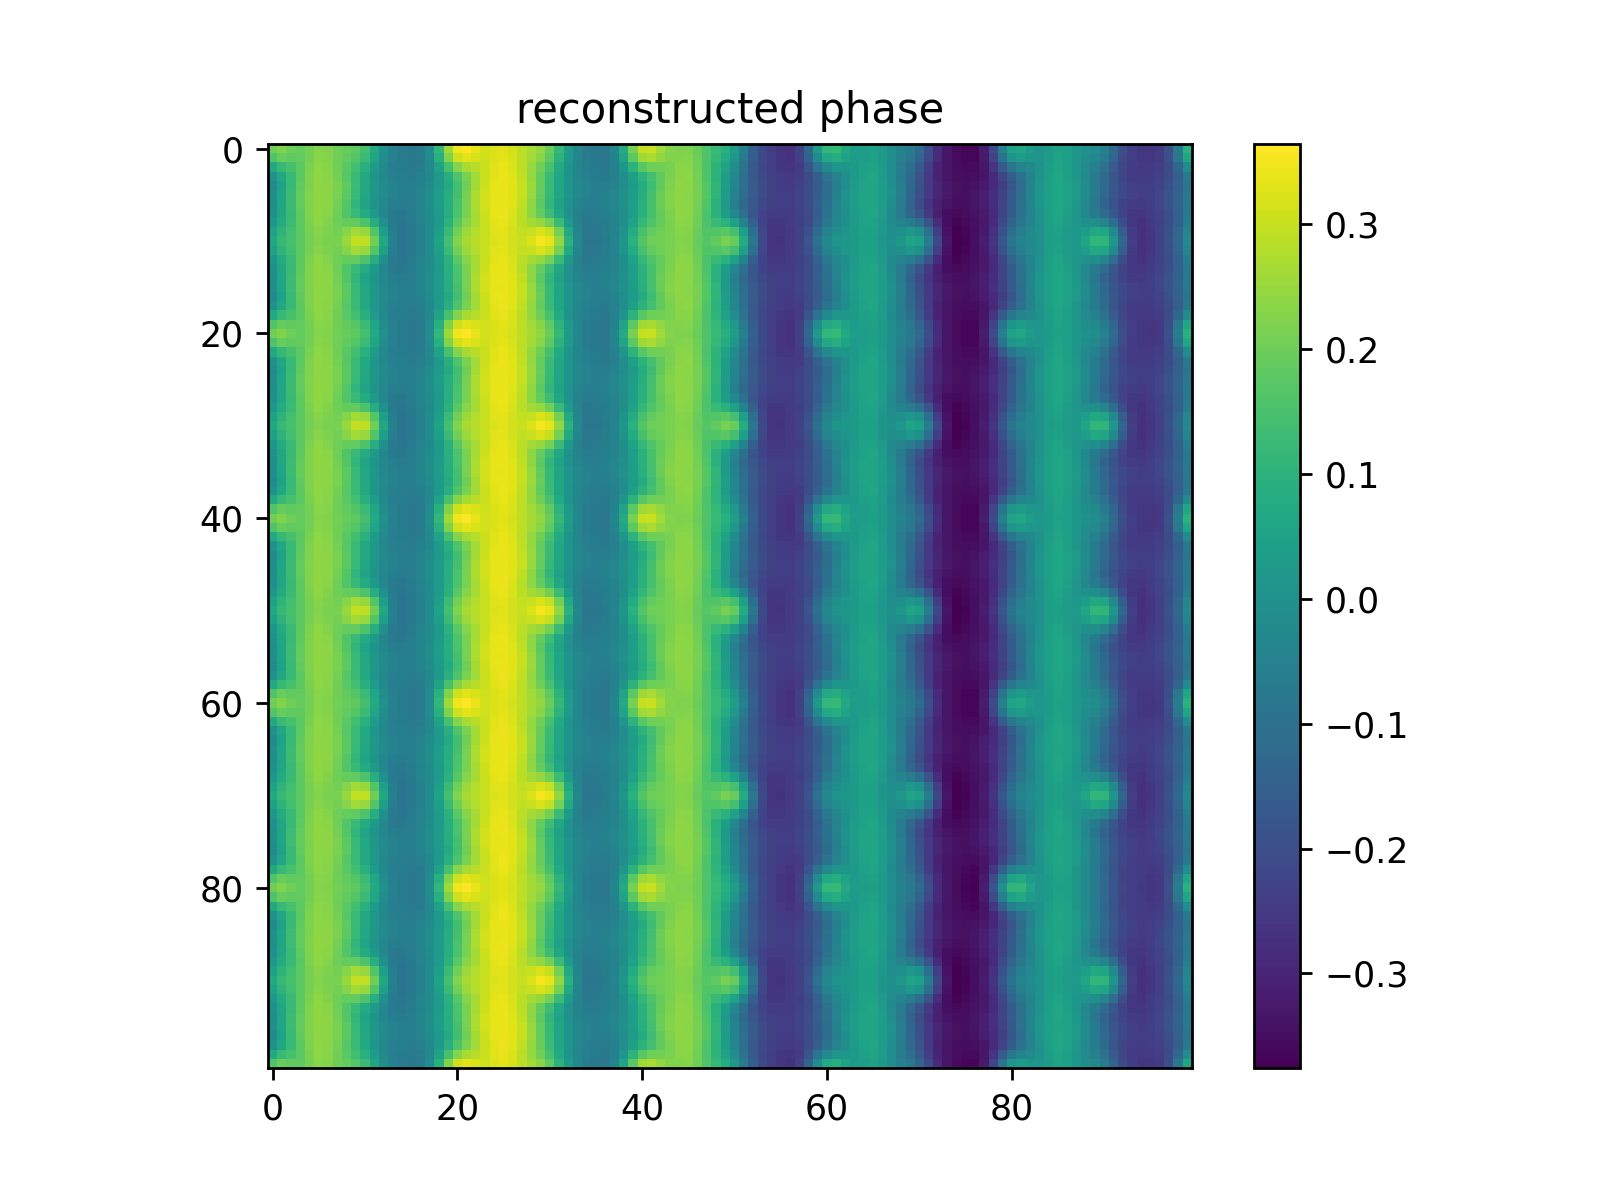

In [17]:
rec = get_results(udf_result)

fig, axes = plt.subplots()
axes.set_title("reconstructed amplitude")
p = axes.imshow(np.abs(rec))
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("reconstructed phase")
p = axes.imshow(np.angle(rec))
fig.colorbar(p)